<table align="center">
  <a target="_blank" href="https://colab.research.google.com/github/martinlf6/schwab-ds-takehome-FengLiu/blob/main/02_aspects.ipynb">
        <img src="https://i.ibb.co/2P3SLwK/colab.png"  style="padding-bottom:5px;" />Run in Google Colab</a>
</table>

In [10]:
# Downgrade the datasets library to load the data correctly.
!pip install datasets==3.6.0 --force-reinstall

  Using cached datasets-3.6.0-py3-none-any.whl.metadata (19 kB)
  Using cached filelock-3.19.1-py3-none-any.whl.metadata (2.1 kB)
  Using cached numpy-2.3.2-cp312-cp312-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl.metadata (62 kB)
  Using cached pyarrow-21.0.0-cp312-cp312-manylinux_2_28_x86_64.whl.metadata (3.3 kB)
  Using cached dill-0.3.8-py3-none-any.whl.metadata (10 kB)
  Using cached pandas-2.3.2-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (91 kB)
  Using cached requests-2.32.5-py3-none-any.whl.metadata (4.9 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
  Using cached xxhash-3.5.0-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (12 kB)
  Using cached multiprocess-0.70.16-py312-none-any.whl.metadata (7.2 kB)
  Using cached fsspec-2025.3.0-py3-none-any.whl.metadata (11 kB)
  Using cached huggingface_hub-0.34.4-py3-none-any.whl.metadata (14 kB)
  Using cached packaging-25.0-py3-none-any.whl.metadata (3.3 kB)
  Using ca

In [10]:
# Install spaCy and python -m to load the spaCy transformer model, en_core_web_trf.
!pip install spacy
!python -m spacy download en_core_web_trf

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 457.4/457.4 MB 1.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_trf')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [1]:
import spacy
import pandas as pd
from datasets import load_dataset

In [2]:
# A) Load dataset
ds = load_dataset("financial_phrasebank", "sentences_50agree") # 'sentences_allagree' means only sentences where all annotators agreed on the sentiment label are included in the loaded dataset. ds is now a DatasetDict object with splits like "train"
df = ds["train"].to_pandas().rename(columns={"sentence":"text","label":"y"}) # Convert to Pandas dataframe. ds["train"] selects the training split of the dataset
label_map = {0: "negative", 1: "neutral", 2: "positive"} # Create a mapping from numbers to labels
df["label"] = df["y"].map(label_map) # Apply the mapping: replaces each numeric value in column y with its text label and creates a new column label with human-readable sentiment.
df["len"] = df["text"].str.split().apply(len) # .split() splits each list in text column (sentence) on whitespace, another word, splits each sentence into words. apply(len) applies the built-in Python len() function to each list in text column (sentence) that gives the number of words in the sentence.

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [3]:
df

,text,y,label,len
0,"According to Gran , the company has no plans t...",1,neutral,25
1,Technopolis plans to develop in stages an area...,1,neutral,31
2,The international electronic industry company ...,0,negative,36
3,With the new production plant the company woul...,2,positive,33
4,According to the company 's updated strategy f...,2,positive,41
...,...,...,...,...
4841,LONDON MarketWatch -- Share prices ended lower...,0,negative,26
4842,Rinkuskiai 's beer sales fell by 6.5 per cent ...,1,neutral,30
4843,Operating profit fell to EUR 35.4 mn from EUR ...,0,negative,23
4844,Net sales of the Paper segment decreased to EU...,0,negative,44


In [4]:
nlp = spacy.load("en_core_web_trf") # Load spaCy transformer model, en_core_web_trf.

In [5]:
def extract_aspects(text):
    doc = nlp(text)
    aspects = []
    # Named entities of interest
    for ent in doc.ents:
        if ent.label_ in {"ORG","PRODUCT","WORK_OF_ART"}:  # extend if needed
            aspects.append(ent.text)
    # Noun chunks for financial facets
    for nc in doc.noun_chunks:
        head = nc.root.lemma_.lower()
        if head in {"revenue","guidance","dividend","yield","fees","costs","margin","outlook","results","stock","shares"}:
            aspects.append(nc.text)
    # dedupe
    aspects = list(dict.fromkeys(a.strip() for a in aspects if len(a.strip())>1))
    return aspects

df["aspects"] = df["text"].apply(extract_aspects)
df["num_aspects"] = df["aspects"].str.len()
print(df[["text","aspects"]].head(10))


KeyboardInterrupt: 

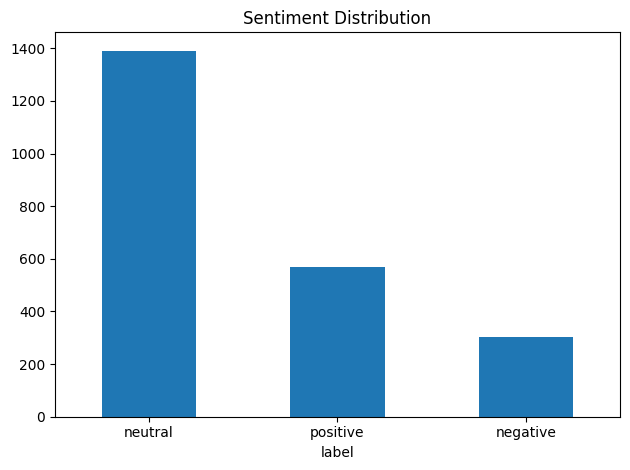

In [ ]:
# C) Visualize sentiment distribution
plt.figure()
df["label"].value_counts().plot(kind="bar", rot=0, title="Sentiment Distribution")
plt.tight_layout()
plt.show()
# The visual shows the data is imblanced with much more neutral sentiment than positive which is more than negative.

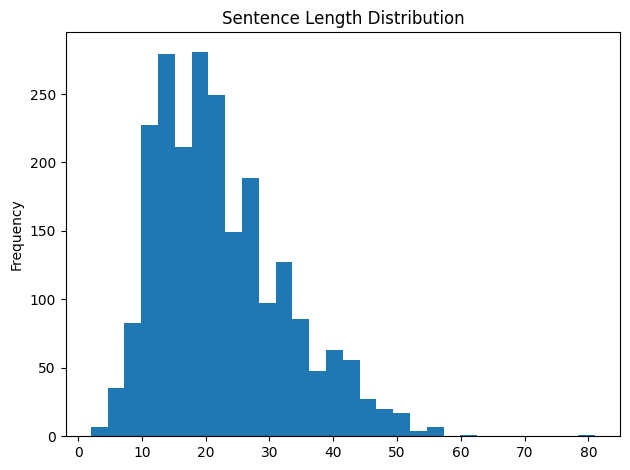

In [ ]:
# D) Sentence length histogram
plt.figure()
df["len"].plot(kind="hist", bins=30, title="Sentence Length Distribution")
plt.tight_layout()
plt.show() # The visual shows it's a right-skewed histogram (mean > median > mode) with the bulk of the data points are settled on the left side, whereas a few extreme values drag the tail on the right.

In [ ]:
# E) Common words per class Loop through each sentiment (simple bag-of-words view)
# Normalization function
def normalize(s):
    s = s.lower() # Converts all text to lowercase.
    s = re.sub(r"[^\w\s]", " ", s) # Replace any character that is not a word (\w) or whitespace (\s) with a space.
    return s

# Define stopwords
stop = set(ENGLISH_STOP_WORDS) | {"s","said","u","’s","—","–","..."} # ENGLISH_STOP_WORDS is a built-in list of common words from scikit-learn (like "the", "and", "is"). These words will be ignored because they don’t carry much meaning.

# Function to get top terms
def top_terms(subset, k=20):
    all_tokens = [] # Define a variable, all_tokens, and assigns it an empty list.
    for t in subset["text"].map(normalize): # Apply normalize() to each sentence in the subset.
        toks = [w for w in t.split() if w not in stop and not w.isdigit()] # Drop stopwords and pure numbers
        all_tokens.extend(toks) # Collects all tokens from all sentences into a big list.
    return Counter(all_tokens).most_common(k) # Counts word frequencies and returns the top k most common tokens.

# Loop through each sentiment
for lab in ["negative","neutral","positive"]:
    print(f"\nTop tokens for {lab}:")
    print(top_terms(df[df["label"]==lab], k=20))



Top tokens for negative:
[('eur', 251), ('mn', 186), ('profit', 122), ('net', 84), ('sales', 72), ('year', 72), ('quarter', 71), ('operating', 68), ('mln', 62), ('period', 58), ('million', 57), ('finnish', 57), ('decreased', 52), ('loss', 51), ('compared', 42), ('m', 40), ('company', 38), ('oyj', 35), ('fell', 35), ('corresponding', 34)]

Top tokens for neutral:
[('company', 225), ('eur', 130), ('finland', 109), ('shares', 105), ('business', 97), ('group', 95), ('million', 91), ('services', 82), ('share', 77), ('market', 61), ('sales', 60), ('finnish', 59), ('new', 59), ('value', 59), ('m', 58), ('total', 56), ('capital', 52), ('products', 49), ('financial', 49), ('helsinki', 45)]

Top tokens for positive:
[('eur', 375), ('mn', 223), ('profit', 172), ('net', 166), ('year', 155), ('sales', 129), ('period', 125), ('million', 118), ('m', 116), ('finnish', 108), ('operating', 103), ('mln', 99), ('quarter', 89), ('company', 86), ('rose', 82), ('increased', 74), ('loss', 60), ('correspondin

In [ ]:
df

,text,y,label,len
0,"According to Gran , the company has no plans t...",1,neutral,25
1,"For the last quarter of 2010 , Componenta 's n...",2,positive,39
2,"In the third quarter of 2010 , net sales incre...",2,positive,29
3,Operating profit rose to EUR 13.1 mn from EUR ...,2,positive,24
4,"Operating profit totalled EUR 21.1 mn , up fro...",2,positive,22
...,...,...,...,...
2259,Operating result for the 12-month period decre...,0,negative,27
2260,HELSINKI Thomson Financial - Shares in Cargote...,0,negative,40
2261,LONDON MarketWatch -- Share prices ended lower...,0,negative,26
2262,Operating profit fell to EUR 35.4 mn from EUR ...,0,negative,23


Bias/Data quality checks to include in the EDA notebook:
*   Class imbalance (e.g., are positive sentences over-represented?): yes, more neutral sentences than positive which is more than negative.
*   Length extremes and distribution (very short/very long): ranging from 2 to 81, with mean of 22 and standard deviation of 10.
*   Duplicates or near-duplicates: million is in different formats such as mn, million, mln and m.
*   Topic/entity imbalance (are a few companies dominating?): more topics related to **eur** (the official currency of European Union), **profit** and **net** (negative and positive).




